---
title: "How to use HDA to find and download data for conducting monitoring of Śniadrwy lake"
subtitle: "This notebook demonstrates a simple example of how you can access data from DEDL using HDA and what you can do with it using an example with Sentinel-1 data."
author: "Author: Eumetsat"
tags: [HDA, STAC, Sentinel-2, satpy]
thumbnail: ../../img/EUMETSAT-icon.png
license: MIT
copyright: "© 2024 EUMETSAT"
---

In this notebook, we will present a simple example on how you can access data from DEDL using HDA and what you can do with it. As an example, we will try to download Sentinel-2 images containining data of Śniadrwy lake from first week of July 2023. With usage of HDA and few Python packages, you will be able to obtain rasters with NDWI index.

# 1. Prerequisites

## 1.1 DestinE account

Firstly, to work with HDA we will need account on DestinE Core Service Platfrom website. You can register under this url: https://platform.destine.eu/

## 1.2 Python's packages

In [ ]:
import requests
import zipfile
import io
import destinelab as deauth
from getpass import getpass

## 1.3 Prerequiared data
Before reuqesting some data from DEDL HDA, let's specify what data we want to obtain. We will define 3 variables:
* Start date and end date,
* Output directory,
* Geometry of interesting us area

`Start date and end date` will define our timerange in reuqest. HDA will search only for products that were obtained between those two dates.

`Output directory` will define directory for downloaded products.

`Geometry` wll define our area of interest. It will be passed as BBOX (Bounding Box), as a list of coordinates - Xmin, Ymin, Xmax, Ymax. All coordinates will be defined in EPSG:4326.

In [ ]:
# Timerange of data that we want to recieve
start_date = '2023-07-01'
end_date = '2023-07-07'
# Output directory of our desired data
output_dir = 'output/'
# Geometry in form of a BBOX
bbox = [21.61868,53.66627,21.90926,53.82351]

# 2. Work with HDA

HDA (Harmonized Data Access) uses STAC protocol, that allows its user access the Earth Observation data, stored in various provides. Thanks to that, HDA serves as an one stream of data, allowing for comfortable work with sattelite imagery.

# 2.1 API URLs

HDA, as all API, is build upon many endpoints. In this notebook we will use only one for collections and searching. Below there are definitions of those endpoints. We will be using the common one site, but you can change it to `central`, `lumi` or `leonardo` if you want.

In [1]:
COLLECTIONS_URL = 'https://hda.data.destination-earth.eu/stac/collections'
SEARCH_URL = 'https://hda.data.destination-earth.eu/stac/search'

# 2.2 Listing available collections
Firstly lets see to which collections we can get access, while using HDA.

In [9]:
def get_stac_collections(api_url):
    response = requests.get(api_url)
    if response.status_code == 200:
        stac_data = response.json()['collections']
        collections = [x['id'] for x in stac_data]
        return collections
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None
    
get_stac_collections(COLLECTIONS_URL)

['EO.CLMS.DAT.CORINE',
 'EO.CLMS.DAT.GLO.DMP300_V1',
 'EO.CLMS.DAT.GLO.FAPAR300_V1',
 'EO.CLMS.DAT.GLO.FCOVER300_V1',
 'EO.CLMS.DAT.GLO.GDMP300_V1',
 'EO.CLMS.DAT.GLO.LAI300_V1',
 'EO.CLMS.DAT.GLO.NDVI300_V1',
 'EO.CLMS.DAT.GLO.NDVI_1KM_V2',
 'EO.CLMS.DAT.SENTINEL-2.HRVPP.VI',
 'EO.DEM.DAT.COP-DEM_GLO-30-DGED',
 'EO.DEM.DAT.COP-DEM_GLO-30-DTED',
 'EO.DEM.DAT.COP-DEM_GLO-90-DGED',
 'EO.DEM.DAT.COP-DEM_GLO-90-DTED',
 'EO.ECMWF.DAT.CAMS_EUROPE_AIR_QUALITY_FORECASTS',
 'EO.ECMWF.DAT.CAMS_EUROPE_AIR_QUALITY_REANALYSES',
 'EO.ECMWF.DAT.CAMS_GLOBAL_ATMOSHERIC_COMPO_FORECAST',
 'EO.ECMWF.DAT.CAMS_GLOBAL_EMISSION_INVENTORIES',
 'EO.ECMWF.DAT.CAMS_GLOBAL_FIRE_EMISSIONS_GFAS',
 'EO.ECMWF.DAT.CAMS_GLOBAL_GREENHOUSE_GAS_REANALYSIS',
 'EO.ECMWF.DAT.CAMS_GLOBAL_GREENHOUSE_GAS_REANALYSIS_MONTHLY_AV_FIELDS',
 'EO.ECMWF.DAT.CAMS_GLOBAL_RADIATIVE_FORCING',
 'EO.ECMWF.DAT.CAMS_GLOBAL_RADIATIVE_FORCING_AUX',
 'EO.ECMWF.DAT.CAMS_GLOBAL_REANALYSIS_EAC4',
 'EO.ECMWF.DAT.CAMS_GLOBAL_REANALYSIS_EAC4_MONTHLY_AV_

As you can see, there are many dataset, that can be access using just one single tool - HDA. In this notebook we will use only Sentinel-2 images, so our collections will be `EO.ESA.DAT.SENTINEL-2.MSI.L1C` and `EO.ESA.DAT.SENTINEL-2.MSI.L2A`.

In [ ]:
collections = ['EO.ESA.DAT.SENTINEL-2.MSI.L1C', 'EO.ESA.DAT.SENTINEL-2.MSI.L2A']

## 2.3 Authorization

As stated before, to use HDA you will need an account on DestinE. Using your credentials, you will be able to generate `access token`, that will be needed in upcoming requests. In listing collections' cell you didn't have to create token, because only more advanced requests (like listing, searching and downloading items) need it.

In [ ]:
DESP_USERNAME = input("Please input your DESP username or email: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Response code: 200
DEDL/DESP Access Token Obtained Successfully


## 2.4 Find newest product
After defining all prerequired data and obtaining access token, we can start searching for interesting us products. To do that, we will firstly create body of a POST request with ours parameters. Then, we will send it to HDA and, if request is successful, we will read from response download link. 

In [12]:
def search_items(access_token: str, search_url: str, collection: str, 
                 bbox: list[float | int], start_date: str, end_date: str):
    body = {
        'datetime': f'{start_date}T00:00:00Z/{end_date}T23:59:59Z',
        'collections': [collection],
        'bbox': bbox
    }
    response = requests.post(search_url, json=body, headers={'Authorization': 'Bearer {}'.format(access_token)})
    if response.status_code != 200:
        print(f'Error in search request: {response.status_code} - {response.text}')
        return None
    else:
        print("Request successful! Reading data...")
        products_list = [(feature.get('assets').get('downloadLink').get('href'), feature.get('links')[0].get('title')) for feature in response.json().get('features', [])]
        return products_list

To obtain products from two levels of Sentinel-2 - L2A and L1C, we will use loop, iterating over every single collection.

In [13]:
collections_items = []
for c in collections:
    collections_items.append(search_items(access_token, SEARCH_URL, c, bbox, start_date, end_date))

Request successful! Reading data...
Request successful! Reading data...


## 2.5 Download founded images
After obtaining download links for each of interesting us product, we can finally download it. With single request, we will download compressed product in zip format to provided directory. Function will set filename as product's id. Mind that Sentinel-2 products might be over 1 GB, so it may take a few minutes to download them, based on your internet connection.

In [12]:
def hda_download(access_token: str, url: str, output: str):
    response = requests.get(url,stream=True,headers={'Authorization': 'Bearer {}'.format(access_token), 'Accept-Encoding': None})
    if response.status_code == 200:
        print('Downloading dataset...')
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            z.extractall(output)
        print('The dataset has been downloaded to: {}'.format(output))
    else:
        print('Request Unsuccessful! Error-Code: {}'.format(response.status_code))

From previous section, we obtained 2D list - with one dimension being collection and second being one item (single product). Becouse of that, we will use two loops to iterate over single products. 

In [13]:
for collection in collections_items:
    for item in collection:
        url = item[0]
        product_id = item[1]
        download_path = output_dir + product_id
        hda_download(access_token, url, download_path)
        break

The dataset has been downloaded to: output/S2B_MSIL1C_20230701T094549_N0509_R079_T34UEE_20230701T104205
The dataset has been downloaded to: output/S2B_MSIL2A_20230701T094549_N0509_R079_T34UEE_20230701T113400


# 4. Simple data computing - obtaining NDWI

In this chapter we will conduct simple data computing. As stated before, this notebook concentrate on monitoring of Śniadrwy lake, so we will try to calculate NDWI index for each pixel and create raster from it. Using all downloaded items, we will be able to monitor lake status from entire month.

## 4.1 Libraries

In this chapter we will try to compute obtained by us imagery data, with usage of Python and its spatial-oriented packages. 

In [14]:
import rasterio
from osgeo import gdal, gdal_array, osr
import numpy as np
import os

## 4.2 Functions for reading, calculating and saving raster data
Here we present you some functions for reading raster data into Numpy matrix, calculating NDWI with NIR and GREEN matrixes and saving result as a new raster. We will conduct such calculation for each downloaded item. In the end, we will obtain NDWI data on Śniadrwy Lake from whole week.

In [37]:
def getFullPath(dir: str, resolution: int, band: str):
    if not os.path.isdir(dir):
        raise ValueError(f"Provided path does not exist: {dir}")
    elif resolution not in [10,20,60]:
        raise ValueError(f"Provided resolution does not exist: R{resolution}m")
    else:
        full_path = dir
        while True:
            content = os.listdir(full_path)
            if len(content) == 0:
                raise ValueError(f"Directory empty: {full_path}")
            elif len(content) == 1:
                if full_path[-1] != '/':
                    full_path = full_path + '/' + content[0]
                else:
                    full_path = full_path + content[0]
            else:
                if 'GRANULE' in content:
                    full_path = full_path + '/' + 'GRANULE'
                    break
                else:
                    raise ValueError(f"Unsupported dir architecture: {full_path}")
        full_path = full_path + '/' + os.listdir(full_path)[0]
        full_path = full_path + '/' + "IMG_DATA"
        if len(os.listdir(full_path)) == 3:
            full_path = full_path + '/' + f'R{resolution}m'
            images = os.listdir(full_path)
            for img in images:
                if band in img:
                    return full_path + '/' + img
            raise ValueError(f'No such band {band} in directory: {full_path}')
        else:
            images = os.listdir(full_path)
            for img in images:
                if band in img:
                    return full_path + '/' + img
            raise ValueError(f'No such band {band} in directory: {full_path}')

# Get transformation matrix from raster
def getTransform(pathToRaster):
    dataset = gdal.Open(pathToRaster)
    transformation = dataset.GetGeoTransform()
    return transformation

# Read raster and return pixels' values matrix as int16, new transformation matrix, crs
def readRaster(path, resolution, band):
    path = getFullPath(path, resolution, band)
    trans = getTransform(path) # trzeba zdefiniować który kanał
    raster, crs = rasterToMatrix(path)
    return raster.astype(np.int16), crs, trans

def rasterToMatrix(pathToRaster):
    with rasterio.open(pathToRaster) as src:
        matrix = src.read(1)
    return matrix, src.crs.to_epsg()

# Transform numpy's matrix to geotiff; pass new raster's filepath, matrix with pixels' values, gdal file type, transformation matrix, projection, nodata value
def npMatrixToGeotiff(filepath, matrix, gdalType, projection, transformMatrix, nodata = None):
    driver = gdal.GetDriverByName('Gtiff')
    if len(matrix.shape) > 2:
        (bandNr, yRes, xRes) = matrix.shape
        image = driver.Create(filepath, xRes, yRes, bandNr, gdalType)
        for b in range(bandNr):
            b = b + 1
            band = image.GetRasterBand(b)
            if nodata is not None:
                band.SetNoDataValue(nodata)
            band.WriteArray(matrix[b-1,:,:])
            band.FlushCache
    else:
        bandNr = 1
        (yRes, xRes) = matrix.shape
        image = driver.Create(filepath, xRes, yRes, bandNr, gdalType)
        print(type(image))
        band = image.GetRasterBand(bandNr)
        if nodata is not None:
            band.SetNoDataValue(nodata)
        band.WriteArray(matrix)
        band.FlushCache
    image.SetGeoTransform(transformMatrix)
    image.SetProjection(projection)
    del driver, image, band

## 4.3 Computing

With usage of defined functions, we will now generate NWDI rasters. Only data that will be needed in this step is a list with paths to our products (extracted from zip archive). Function `readRaster` will choose specified band from specified path.

In [ ]:
# List of products' paths. If your output directory contains more than just downloaded products, please provide them in a list, just like in the commented lines below
#dataset = [output_dir+x for x in os.listdir(output_dir)]
dataset = [
     'output/S2B_MSIL1C_20230701T094549_N0509_R079_T34UEE_20230701T104205'
 ]
# Output directiry for new images
compution_output = 'output/ndwi_rasters'

# Iterating over single product
for item in dataset:
    # Reading name from path
    name = item.split('/')[-1]
    # Reading green band into matrix
    green = readRaster(item, 10, 'B03')
    # Reading NIR band into matrix
    nir = readRaster(item, 10, 'B08')
    # Calculating NDWI matrix
    ndwi = (green[0]-nir[0]) / (green[0]+nir[0])
    # Setting treshhold for water-containing pixels
    ndwi[ndwi >= 0] = 1
    ndwi[ndwi < 0] = 0
    # Creating SpatialReference object and setting it to match original's raster CRS
    projection = osr.SpatialReference()
    projection.ImportFromEPSG(green[1])
    # Creating raster from matrix in GeoTiff format
    npMatrixToGeotiff(f'{compution_output}/{name}.tif', ndwi, gdal_array.NumericTypeCodeToGDALTypeCode(np.float32), projection.ExportToWkt(), green[2])

/tmp/ipykernel_14887/1055239620.py:18: RuntimeWarning: invalid value encountered in divide
  ndwi = (green[0]-nir[0]) / (green[0]+nir[0])


<class 'osgeo.gdal.Dataset'>


After successfuly creating and saving new images, we can now visualize them in Python using raterio package.

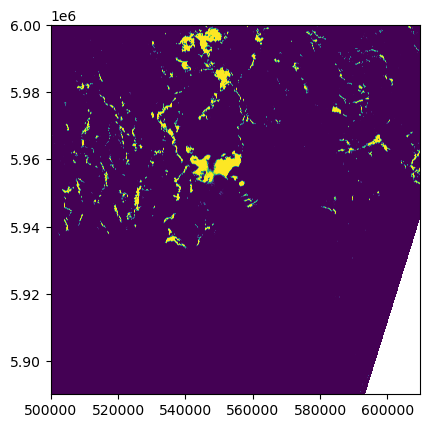

<Axes: >

In [ ]:
img = rasterio.open('output/ndwi_rasters/S2B_MSIL1C_20230701T094549_N0509_R079_T34UEE_20230701T104205.tif')
from rasterio.plot import show
show(img)